In [1]:
import os
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
from collections import deque
from itertools import chain

# read in data

In [3]:
mtx_path = '/public21/home/sc90258/huangying/analysis/12.pan_mosquito/20241225_rerun_mtx-stand_by/1.aae/2.mtx/shell/aae-bl/outs/filtered'
adata = sc.read_10x_mtx(mtx_path)

adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 12501 × 19269
    var: 'gene_ids', 'feature_types'

In [4]:
adata.var_names

Index(['LOC110674347', 'LOC110674348', 'LOC5575839', 'LOC5575838',
       'LOC5575837', 'LOC110674706', 'LOC5575836', 'LOC5575835', 'LOC5575834',
       'LOC5575833',
       ...
       'CFI06_mgp02', 'CFI06_mgt18', 'CFI06_mgp01', 'CFI06_mgt19',
       'CFI06_mgr02', 'CFI06_mgt20', 'CFI06_mgr01', 'CFI06_mgt21',
       'CFI06_mgt22', 'CFI06_mgt23'],
      dtype='object', length=19269)

# QC

## mark mitochondrial genes

In [5]:
# mitochondrial genes
mt_genes = ('CFI06_mgt01', 'CFI06_mgp13', 'CFI06_mgt02', 'CFI06_mgt03', 'CFI06_mgt04', 'CFI06_mgp12', 'CFI06_mgt05', 'CFI06_mgp11', 'CFI06_mgt06', 'CFI06_mgt07', 'CFI06_mgp10', 'CFI06_mgp09', 'CFI06_mgp08', 'CFI06_mgt08', 'CFI06_mgp07', 'CFI06_mgt09', 'CFI06_mgt10', 'CFI06_mgt11', 'CFI06_mgt12', 'CFI06_mgt13', 'CFI06_mgt14', 'CFI06_mgp06', 'CFI06_mgt15', 'CFI06_mgp05', 'CFI06_mgp04', 'CFI06_mgt16', 'CFI06_mgt17', 'CFI06_mgp03', 'CFI06_mgp02', 'CFI06_mgt18', 'CFI06_mgp01', 'CFI06_mgt19', 'CFI06_mgr02', 'CFI06_mgt20', 'CFI06_mgr01', 'CFI06_mgt21', 'CFI06_mgt22', 'CFI06_mgt23')

adata.var["mt"] = adata.var_names.map(lambda x: str(x) in mt_genes)

## calculate QC metrics

In [6]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 12501 × 19269
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [7]:
adata.obs['pct_counts_mt'].median()

np.float32(10.303256)

## plot QC plot before do filtering 

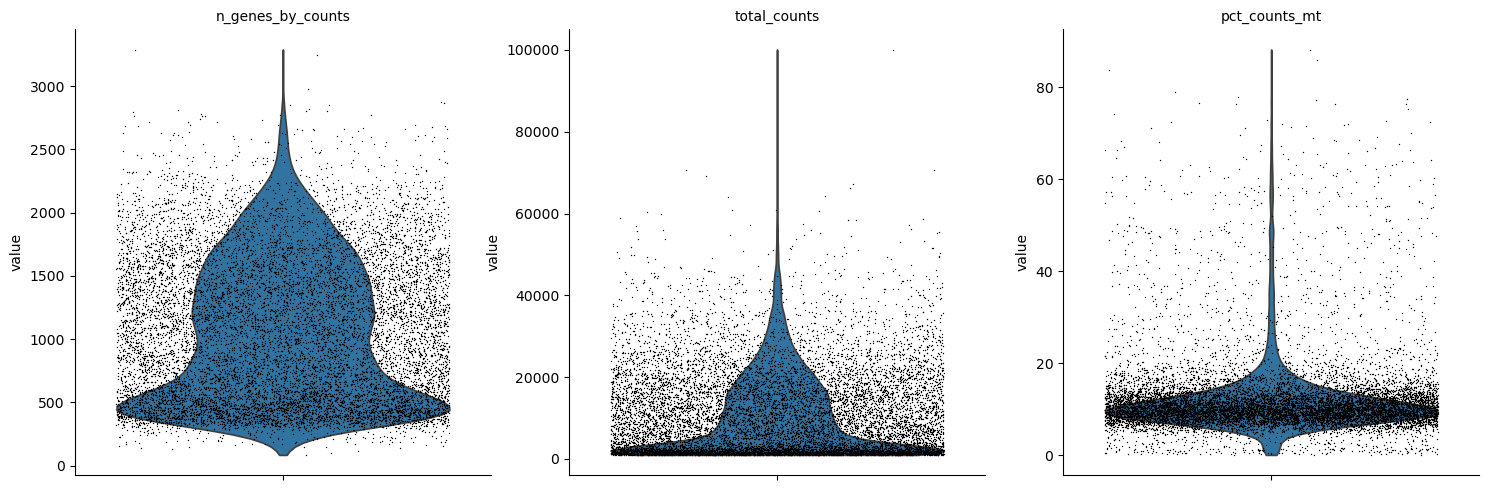

In [8]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

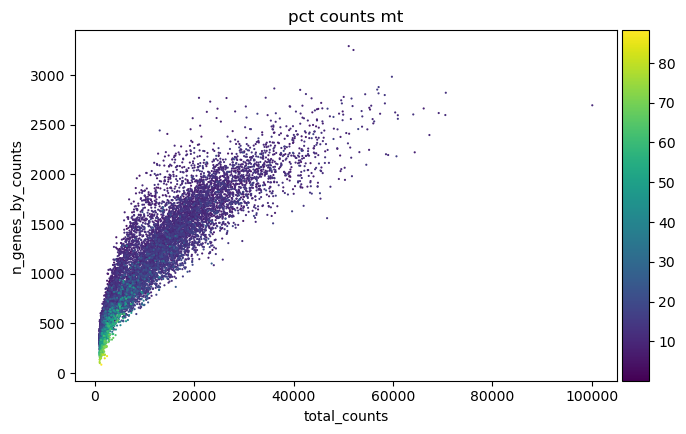

In [9]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## plot QC plot after do filtering 

In [10]:
# maximum percent.mt
max_percent_mt = 15

adata.obs["mt_outlier"] = (
    adata.obs["pct_counts_mt"] > max_percent_mt
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    10554
True      1947
Name: count, dtype: int64

In [11]:
# QC thresholds
min_n_genes_by_counts = 100
# maximum nFeature_RNA
max_n_genes_by_counts = 2500


adata.obs["genes_outlier"] = \
    (adata.obs.n_genes_by_counts < min_n_genes_by_counts) | \
    (adata.obs.n_genes_by_counts > max_n_genes_by_counts)
adata.obs.genes_outlier.value_counts()

genes_outlier
False    12419
True        82
Name: count, dtype: int64

In [12]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[
    (~adata.obs.mt_outlier) & \
    (~adata.obs.genes_outlier)
].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 12501
Number of cells after filtering of low quality cells: 10478


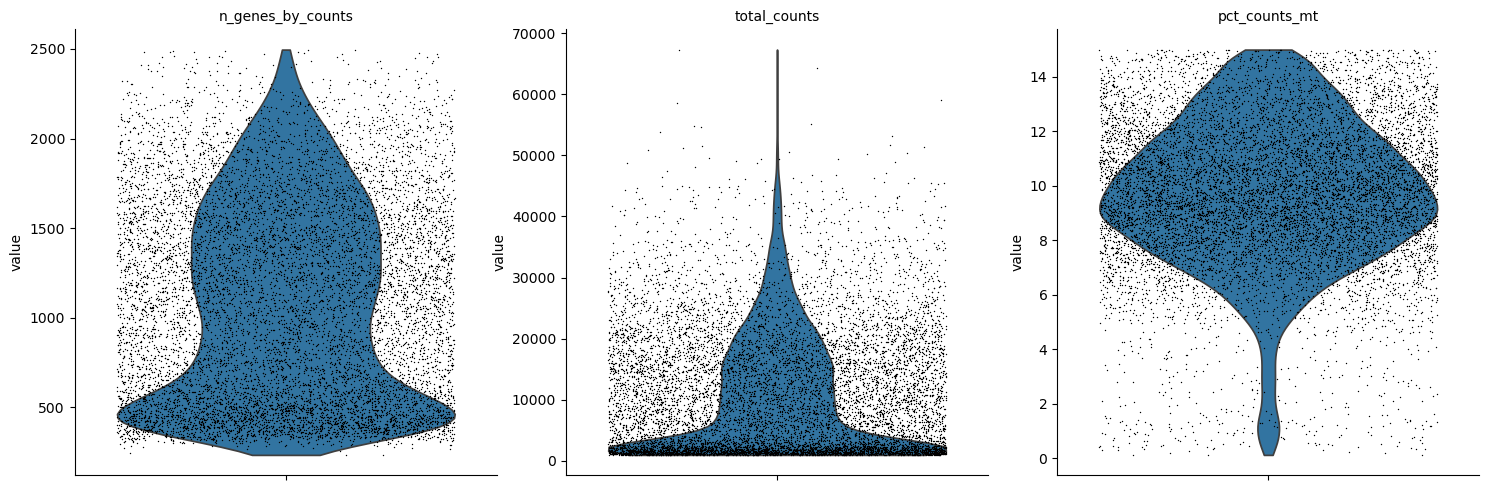

In [13]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

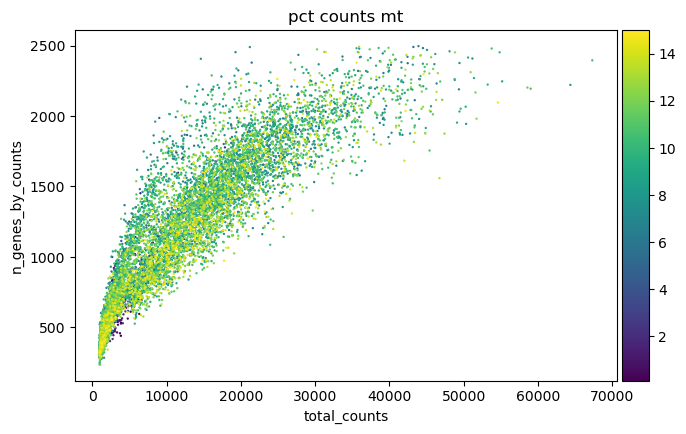

In [14]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [15]:
adata.obs.n_genes_by_counts.median()

np.float64(1044.0)

In [16]:
adata.obs.total_counts.median()

np.float32(8428.0)

## write QC data for doublets check

In [17]:
Rscript = """library(dplyr)
library(Seurat)
library(ggplot2)
library(future)
library(Cairo)
library(DoubletFinder)
library(Matrix)
library(SeuratDisk)

args <- commandArgs(trailingOnly = TRUE)

## read in file --------------------------------------------------------
# path to 10x directory
ipath = args[1]
# 'project' in 'CreateSeuratObject'
project = 'midgut'
# read in file
data10x = Read10X(
    data.dir = ipath
)
# make Seurat object of RNA data
# create Seurat object
seurat_obj =  CreateSeuratObject(
    counts = data10x, 
    assay = "RNA",
    project = project, 
    min.cells = 3
)
## do normalization --------------------------------------------------------
seurat_obj <- NormalizeData(seurat_obj, normalization.method = "LogNormalize", scale.factor = 10000)
# feature selection
# Identification of highly variable features
seurat_obj <- FindVariableFeatures(seurat_obj, selection.method = "vst", nfeatures = 2000)
# scaling data
all.genes <- rownames(seurat_obj)
seurat_obj <- ScaleData(seurat_obj, features = all.genes)

## PCA reduce dimension ----------------------------------------------------
seurat_obj <- RunPCA(seurat_obj, features = VariableFeatures(object = seurat_obj))
# runUMAP
seurat_obj <- RunUMAP(seurat_obj, dims = 1:50)

# https://cloud.tencent.com/developer/article/1825672
nExp <- round(ncol(seurat_obj) * 0.04)  # expect 4% doublets
data.filt <- doubletFinder_v3(
    seurat_obj, 
    pN = 0.25, # https://cloud.tencent.com/developer/article/1825672
    pK = 0.09, 
    nExp = nExp, 
    PCs = 1:50)

DF.name = colnames(data.filt@meta.data)[grepl("DF.classification", colnames(data.filt@meta.data))]

DimPlot(data.filt, group.by = DF.name)

# save seurat_obj
opath_seurat_obj = './mark_doublet/mark_doublet.seurat_obj.rds'
saveRDS(data.filt, file = opath_seurat_obj)
# write h5ad file
SaveH5Seurat(data.filt, filename = "./mark_doublet/mark_doublet.seurat_obj.h5Seurat")
Convert("./mark_doublet/mark_doublet.seurat_obj.h5Seurat", dest = "h5ad")
"""

In [18]:
os.mkdir('./mark_doublet')
with open('./mark_doublet/DoubletFinder.R', 'wt') as f:
    f.write(Rscript)
os.system(f'~/miniconda3/envs/hy-seurat/bin/Rscript ./mark_doublet/DoubletFinder.R {mtx_path}')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Attaching SeuratObject
Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat
Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Centering and scaling data matrix
  |========================================

[1] "Creating 4167 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."


Performing log-normalization
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


[1] "Finding variable genes..."


Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


[1] "Scaling data..."


Centering and scaling data matrix
  |======================================================================| 100%


[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


Creating h5Seurat file for version 3.1.5.9900
Adding counts for RNA
Adding data for RNA
Adding scale.data for RNA
Adding variable features for RNA
Adding feature-level metadata for RNA
Adding cell embeddings for pca
Adding loadings for pca
No projected loadings for pca
Adding standard deviations for pca
No JackStraw data for pca
Adding cell embeddings for umap
No loadings for umap
No projected loadings for umap
No standard deviations for umap
No JackStraw data for umap
Validating h5Seurat file
Adding scale.data from RNA as X
Transfering meta.features to var
Adding data from RNA as raw
Transfering meta.features to raw/var
Transfering meta.data to obs
Adding dimensional reduction information for pca
Adding feature loadings for pca
Adding dimensional reduction information for umap


0

## remove doublets

In [19]:
# read in data marked doublets
dblets = sc.read('./mark_doublet/mark_doublet.seurat_obj.h5ad')
dblets

AnnData object with n_obs × n_vars = 12501 × 11604
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pANN_0.25_0.09_500', 'DF.classifications_0.25_0.09_500'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [20]:
# remove doublets
dblets_col = [i for i in dblets.obs.columns if i.startswith('DF.classifications_')][0]
sglets_obs = dblets.obs[dblets.obs[dblets_col] == 'Singlet'].index
adata = adata[adata.obs.index.isin(sglets_obs)]
adata

View of AnnData object with n_obs × n_vars = 10046 × 19269
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## save AnnData after QC

In [21]:
# save data
adata.write("1.QC.h5ad")
# show AnnData
adata

View of AnnData object with n_obs × n_vars = 10046 × 19269
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

# Normalization

In [2]:
# read in data
adata = sc.read('./1.QC.h5ad')
adata

AnnData object with n_obs × n_vars = 10046 × 19269
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [3]:
# normalization 
sc.pp.normalize_total(
    adata, 
    target_sum=1e6, 
    exclude_highly_expressed=True
)
# Logarithmize
sc.pp.log1p(adata)

# show AnnData
adata

AnnData object with n_obs × n_vars = 10046 × 19269
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'

In [4]:
# save data
adata.write("2.normalization.h5ad")

# Feature Selection

In [5]:
# read in data
adata = sc.read('./2.normalization.h5ad')
adata

AnnData object with n_obs × n_vars = 10046 × 19269
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'

In [6]:
# find highly variable genes
sc.pp.highly_variable_genes(
    adata, n_top_genes=4000, 
    flavor='seurat_v3'
)
# save original AnnData to `.raw` attribute
adata.raw = adata
# only keeping highly variable genes in AnnData
adata = adata[:, adata.var.highly_variable]
# scale each gene to unit variance
sc.pp.scale(adata)
# show AnnData
adata

/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 10046 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

In [7]:
# save data
adata.write("3.after_feature_selection.h5ad")

# dimensional reduction

In [8]:
# read in data
adata = sc.read('./3.after_feature_selection.h5ad')
adata

AnnData object with n_obs × n_vars = 10046 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'

/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


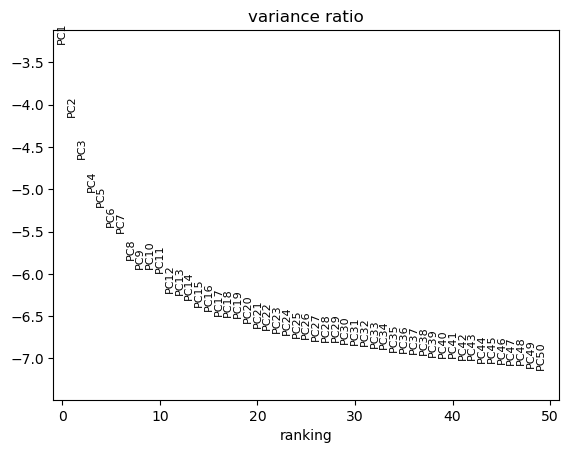

In [9]:
# run PCA
sc.pp.pca(adata, svd_solver="auto", use_highly_variable=True)
# plot single PCs to the total variance in the data
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

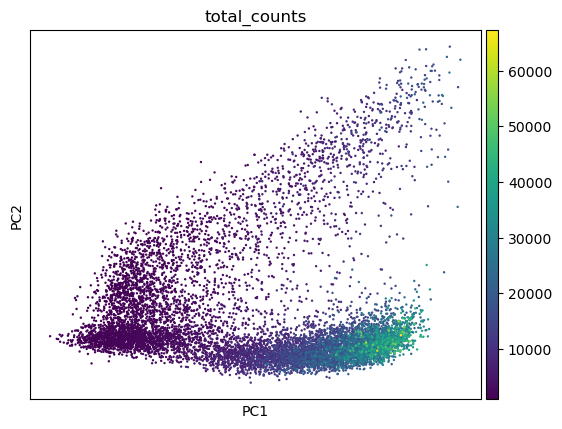

In [10]:
sc.pl.pca_scatter(adata, color="total_counts")

In [11]:
# save data
adata.write("4.PCA.h5ad")
# show AnnData
adata

AnnData object with n_obs × n_vars = 10046 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

# clustering

In [16]:
# read in data
adata = sc.read('./4.PCA.h5ad')
adata

AnnData object with n_obs × n_vars = 10046 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## plot UMAP

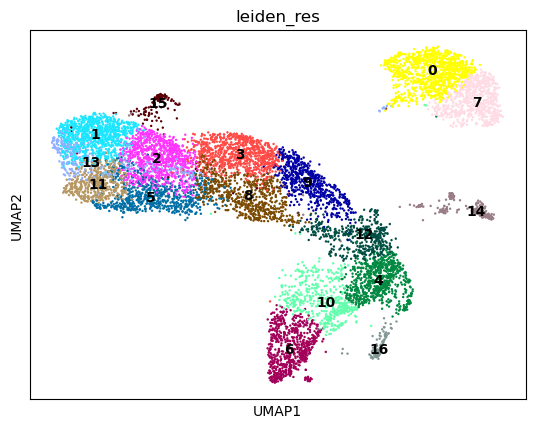

In [19]:
adata = sc.pp.neighbors(adata, n_neighbors=50, n_pcs=30, copy=True)
sc.tl.umap(
    adata, 
    min_dist=0.3
)
sc.tl.leiden(
    adata, 
    key_added="leiden_res", 
    resolution=1.2,
)
sc.pl.umap(
    adata,
    color=["leiden_res"],
    legend_loc="on data",
)

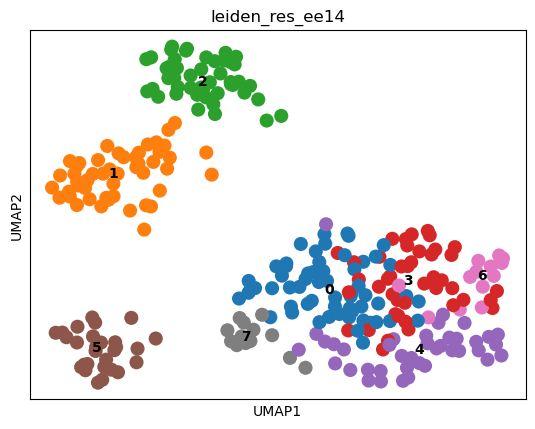

In [20]:
ee14 = adata[adata.obs['leiden_res'] == '14']

ee14 = sc.pp.neighbors(ee14, copy=True)
sc.tl.umap(
    ee14, 
    min_dist=0.3
)
sc.tl.leiden(
    ee14, 
    key_added="leiden_res_ee14", 
    resolution=1.2,
)
sc.pl.umap(
    ee14,
    color=["leiden_res_ee14"],
    legend_loc="on data",
)

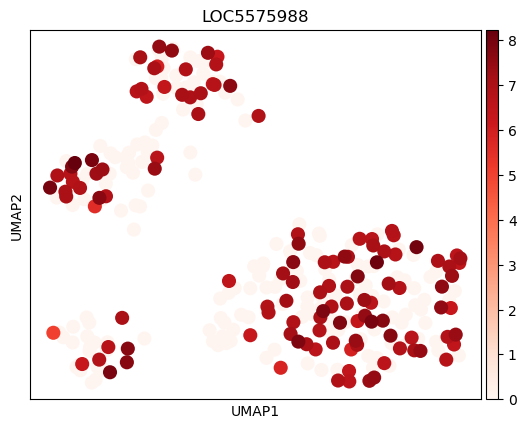

In [21]:
sc.pl.umap(ee14, color='LOC5575988', cmap='Reds') # prospero

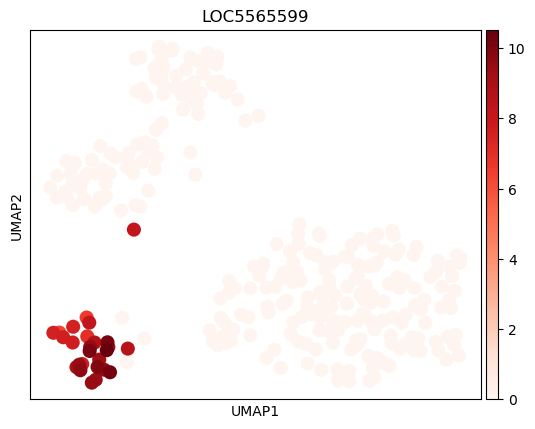

In [22]:
sc.pl.umap(ee14, color='LOC5565599', cmap='Reds') # CCHa2 EE-4

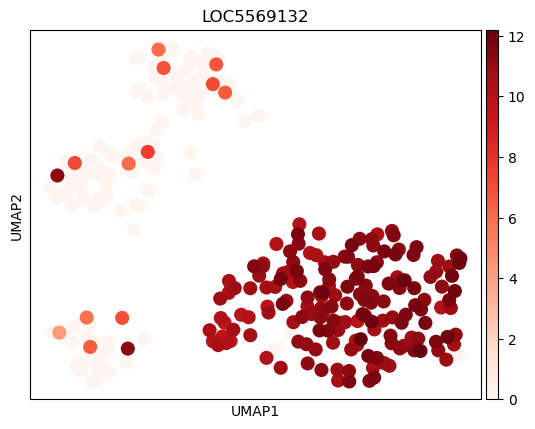

In [23]:
sc.pl.umap(ee14, color='LOC5569132', cmap='Reds') # orcokinin

In [24]:
ee14.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,mt_outlier,genes_outlier,leiden_res,leiden_res_ee14
TGTGAGTCA_ACGTTACGA_AACAAGTGG,849,6.745236,2859.0,7.958577,29.765652,206.0,5.332719,7.205317,False,False,14,1
ACGAATGGA_TGGTAACCG_AACAGGAAC,554,6.318968,1694.0,7.435438,39.846517,167.0,5.123964,9.858324,False,False,14,0
CAGGACTTC_ACCTCGACT_AACCGTGAT,460,6.133398,1212.0,7.100852,38.201320,125.0,4.836282,10.313531,False,False,14,4
CGCAACTAC_AGACGAAGT_AAGATCTGC,621,6.432940,1809.0,7.501082,38.363737,213.0,5.365976,11.774461,False,False,14,4
CGGTGATTG_TCAGGTAGA_AAGATCTGC,741,6.609349,1949.0,7.575585,31.965110,218.0,5.389072,11.185223,False,False,14,2
...,...,...,...,...,...,...,...,...,...,...,...,...
AACACACAG_TGAGGCCTT_TTCAACAGC,448,6.107023,1360.0,7.215975,46.250000,172.0,5.153292,12.647059,False,False,14,3
CCAGCTAAC_CACGCAATA_TTCAAGCTG,468,6.150603,1053.0,6.960348,37.132004,147.0,4.997212,13.960114,False,False,14,4
TGCCTGATC_TAATGGCCG_TTCGGTCAA,486,6.188264,1271.0,7.148346,41.699449,74.0,4.317488,5.822187,False,False,14,4
CTTGACGTT_AGACGAAGT_TTGTCGCTC,648,6.475433,2984.0,8.001355,43.967828,331.0,5.805135,11.092493,False,False,14,5


In [25]:
ee1 = ee14.obs[~ee14.obs['leiden_res_ee14'].isin(['1', '2', '5'])]
ee3 = ee14.obs[ee14.obs['leiden_res_ee14'].isin(['1', '2'])]
ee4 = ee14.obs[ee14.obs['leiden_res_ee14'] == '5']

In [27]:
ee1.to_csv('./ee1.obs.csv')
ee3.to_csv('./ee3.obs.csv')
ee4.to_csv('./ee4.obs.csv')

In [14]:
adata.obs['leiden_res'].value_counts()

leiden_res
0     1032
1      892
2      872
3      854
4      734
5      701
6      692
7      690
8      656
9      623
10     491
11     478
12     443
13     374
14     291
15     126
16      97
Name: count, dtype: int64

In [15]:
# save data
adata.write("5.cluster.h5ad")
# show AnnData
adata

AnnData object with n_obs × n_vars = 10046 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier', 'leiden_res'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden_res', 'leiden_res_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Annotation

In [2]:
# read in data
adata = sc.read('./5.cluster.h5ad')
adata

AnnData object with n_obs × n_vars = 10046 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier', 'leiden_res'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden_res', 'leiden_res_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## make marker genes dict (Culex pipiens pallens)

In [3]:
marker_genes = {
    'ISC/EB': ['LOC5563695','LOC5578162', 'LOC5580156', 'LOC5570443', 'LOC110676293', 'LOC5580247'], # fibulin-1, Klu, Delta, esg
    'Cardia': ['LOC5564993', 'LOC5579458'], # GAM1, LYZ1 ['LOC5568253', 'LOC5572257'] FCN3, CTRB2
    'EC': ['LOC23687865', 'LOC5573855'], # Nub, CPA-VII
    'EC-like': ['LOC5571803', 'LOC5574806', 'LOC5570613'], # CAH7, Cht10, SNAT1, LYZL
    'EE': ['LOC5575988', 'LOC5569132', 'LOC5575886', 'LOC5573874'], # prospero, npf, orcokinin, Calexcitin-1
    'VM':['LOC5571832'], # actin
    'FBC':['LOC5571084'], # apolipophorin-3
    'HC':['LOC5570883', 'LOC110674010'], # LRIM16, NimB2
}

In [4]:
g_n = {k: v \
    for k, v in zip(['LOC5563695', 'LOC5578162', 'LOC5580156', 'LOC5570443', 'LOC5564993', 'LOC5579458', 'LOC23687865', 'LOC5573855', 'LOC5571803', 'LOC5574806', 'LOC5570613', 'LOC110676293', 'LOC5575988', 'LOC5575886', 'LOC5569132', 'LOC5573874', 'LOC5571832', 'LOC5571084', 'LOC5570883', 'LOC110674010', 'LOC5580247'],
    ['fibulin-1', 'Klu', 'Delta', 'esg', 'GAM1', 'LYSC', 'Nubbin', 'CPA-VII', 'CAH7', 'Cht10', 'SNAT1', 'LYSC11', 'prospero', 'npf', 'orcokinin', 'Calexcitin-1', 'actin', 'apolipophorin-3', 'LRIM16', 'NimB2', 'PCNA'])
}
g_n

{'LOC5563695': 'fibulin-1',
 'LOC5578162': 'Klu',
 'LOC5580156': 'Delta',
 'LOC5570443': 'esg',
 'LOC5564993': 'GAM1',
 'LOC5579458': 'LYSC',
 'LOC23687865': 'Nubbin',
 'LOC5573855': 'CPA-VII',
 'LOC5571803': 'CAH7',
 'LOC5574806': 'Cht10',
 'LOC5570613': 'SNAT1',
 'LOC110676293': 'LYSC11',
 'LOC5575988': 'prospero',
 'LOC5575886': 'npf',
 'LOC5569132': 'orcokinin',
 'LOC5573874': 'Calexcitin-1',
 'LOC5571832': 'actin',
 'LOC5571084': 'apolipophorin-3',
 'LOC5570883': 'LRIM16',
 'LOC110674010': 'NimB2',
 'LOC5580247': 'PCNA'}

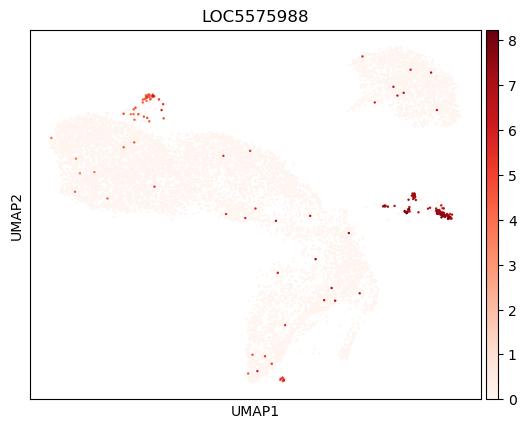

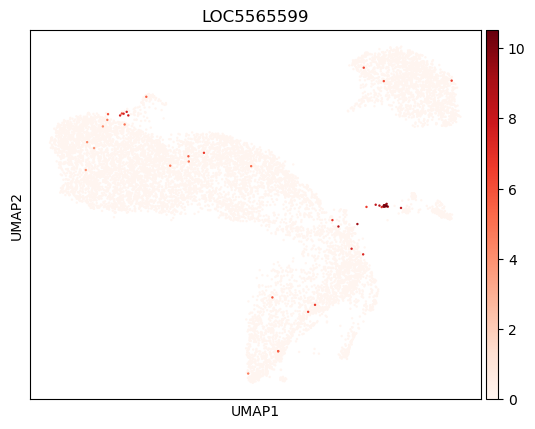

In [13]:
sc.pl.umap(adata, color='LOC5565599', cmap='Reds')

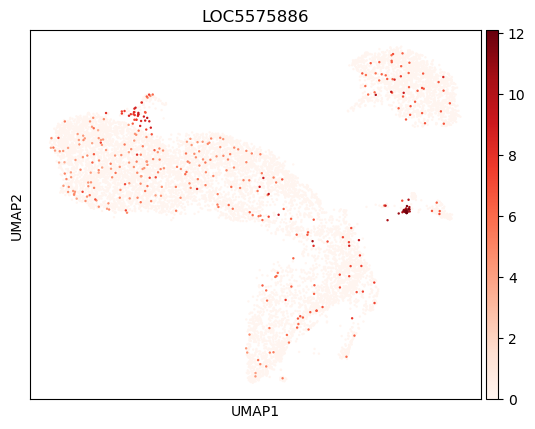

In [14]:
sc.pl.umap(adata, color='LOC5575886', cmap='Reds')

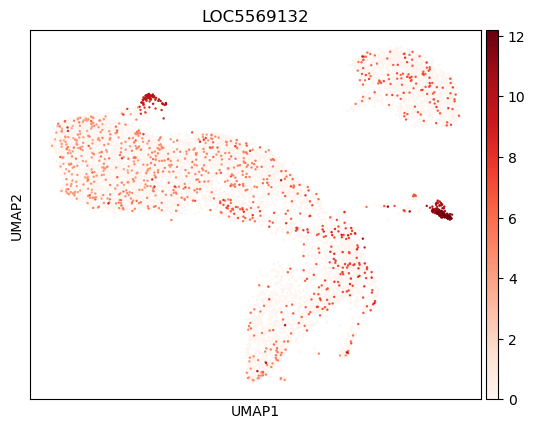

In [15]:
sc.pl.umap(adata, color='LOC5569132', cmap='Reds')

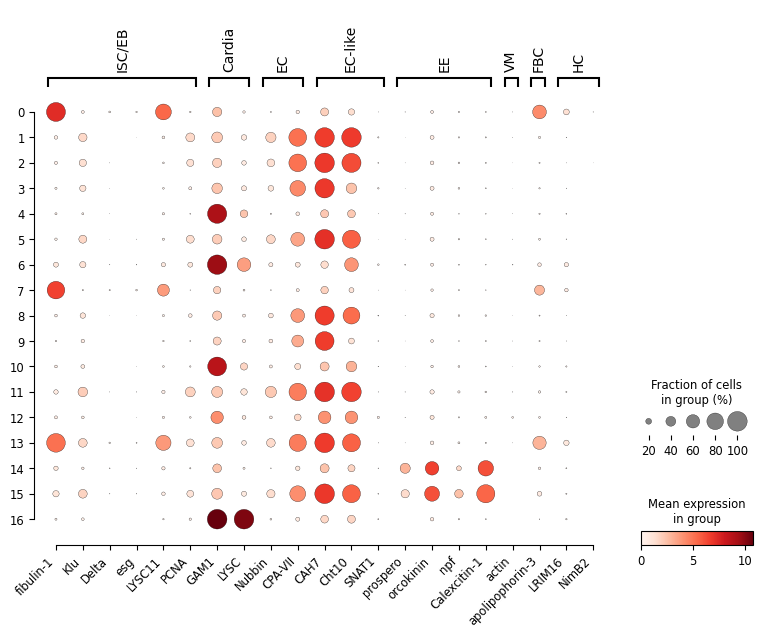

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sc.pl.dotplot(
    adata,
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='leiden_res',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
)

axm = ax['mainplot_ax']

axm.set_xticklabels(
    [g_n[i.get_text()] for i in axm.get_xticklabels()],
    rotation=45, ha='right')
# axm.set_yticklabels(marker_genes.keys())

sns.despine(top=True, right=True, trim=1, ax=axm)

In [6]:
n_id = {
    'ISC/EB': ['7'],
    'ISC/EB-prol': ['0'],
    'Cardia-1': ['16'],
    'Cardia-2': ['4', '6', '10'],
    'EC': ['1', '2', '5', '11', '13'],
    'EC-like-1': ['8', '9', '3'],
    'EC-like-2': ['12'],
    # 'EC-like-3': ['16'],
    'EE-1': ['14'],
    'EE-2': ['15'],
    # 'EE-3': ['13'],
    # 'VM': ['19'],
}

In [7]:
sorted([int(i) for i in chain(*[i for i in n_id.values()]) if i != ''])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [8]:
id_n = {}
for k, v in n_id.items():
    for i in v:
        id_n[i] = k

id_n

{'7': 'ISC/EB',
 '0': 'ISC/EB-prol',
 '16': 'Cardia-1',
 '4': 'Cardia-2',
 '6': 'Cardia-2',
 '10': 'Cardia-2',
 '1': 'EC',
 '2': 'EC',
 '5': 'EC',
 '11': 'EC',
 '13': 'EC',
 '8': 'EC-like-1',
 '9': 'EC-like-1',
 '3': 'EC-like-1',
 '12': 'EC-like-2',
 '14': 'EE-1',
 '15': 'EE-2'}

In [9]:
adata.obs['cluster'] = adata.obs['leiden_res'].map(
    lambda x: id_n[x] if x in id_n.keys() else x)

In [10]:
adata.obs['cluster_name'] = adata.obs['cluster']
adata.obs['cluster_name'] = adata.obs['cluster_name'].astype('category')
adata.obs['cluster_name'] = adata.obs[
        'cluster_name'
    ].cat.reorder_categories(n_id.keys(), ordered=True)

adata.obs['cluster_name'].unique()

['EC', 'EE-1', 'EC-like-1', 'EC-like-2', 'ISC/EB', 'ISC/EB-prol', 'Cardia-2', 'Cardia-1', 'EE-2']
Categories (9, object): ['ISC/EB' < 'ISC/EB-prol' < 'Cardia-1' < 'Cardia-2' ... 'EC-like-1' < 'EC-like-2' < 'EE-1' < 'EE-2']

In [11]:
adata.write('./6.ann.h5ad')

In [12]:
# save fig
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.use('cairo')

ax = sc.pl.dotplot(
    adata,
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='cluster_name',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
)

axm = ax['mainplot_ax']

axm.set_xticklabels(
    [g_n[i.get_text()] for i in axm.get_xticklabels()],
    rotation=45, ha='right')
# axm.set_yticklabels(marker_genes.keys())

sns.despine(top=True, right=True, trim=1, ax=axm)
plt.savefig('aaebl_dotplot.pdf', bbox_inches='tight')
plt.close()

In [34]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns

matplotlib.use('cairo')

fig, ax = plt.subplots(figsize=(8, 6))

# c = sns.color_palette('deep')
# set1 = sns.color_palette('Set1')
# set2 = sns.color_palette('Set2')
# def get_c(lst):
#     rc = ["#a4cde1","#67a4cc","#277fb8","#549da3","#96cb8f","#8bc96d","#4dae47","#5c9e43","#b79973","#f38989","#ec5051","#e32427","#ef6a45","#f9b769","#f9a341","#f48521","#ee8e46","#d4a6a8","#af93c4","#8660a8","#815e99","#c6b598","#f6f28f","#d4a55b","#b05a28"]
#     c = []
#     for i in lst:
#         c.append(rc[i])
#     return c.copy()
c = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD",
    "#8C564B", "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF",
    "#FFD700", "#8B008B", "#00CED1", "#FF4500"]
cells = ['ISC/EB', 'ISC/EB-prol', 'Cardia-1', 'Cardia-2', 'EC', 'EC-like-1', 'EC-like-2', 'EC-like-3', 'EE-1', 'EE-2', 'EE-3', 'VM', 'FBC', 'HC']

umap = pd.DataFrame(
    adata.obsm['X_umap'], 
    columns=['umap1', 'umap2'],
    index=adata.obs.index
)

grp_color = {k:v for k, v in zip(cells, c)}

for lb in n_id.keys():
    pdf = umap[adata.obs['cluster_name'] == lb]
    l1, = ax.plot(
        pdf['umap1'], pdf['umap2'], '.', color=grp_color[lb],
        alpha=0.6, ms=1.5, clip_on = False)

x = 1.8; y = -2.4

ax.arrow(
    x-6.5, y-3, 0, 2.2, 
    width=0.01, head_width=0.2, overhang=0.3, 
    color='k', zorder=10)
ax.arrow(
    x-6.5, y-3, 3, 0, 
    width=0.01, head_width=0.2, overhang=0.3,
    color='k', zorder=10)

ax.set_axis_off()

ax.text(x-4.8, y-3.1, 'UMAP-1', ha='center', va='top')
ax.text(x-6.5, y-2, 'UMAP-2', ha='right', va='center', rotation=90)

for i, (cell, color) in enumerate(grp_color.items()):
    x = 6; y = -1.5
    sep = 7
    j = i // sep

    ax.plot(x + j * 6, y - (i % sep) * 0.6, '.', color=color, mec=color, ms=11, alpha=0.9, clip_on = False)
    ax.text(x + j * 6 + 0.5, y - (i % sep) * 0.6, 
    f'{cell}: {len(adata.obs[adata.obs["cluster_name"] == cell])}', 
    ha='left', va='center', clip_on = False, fontsize=10)

# plt.savefig('./plots/f2.clust.umap_merge.png', dpi=600, bbox_inches='tight')
plt.savefig('aaebl_umap.pdf', bbox_inches='tight')
plt.close()

In [2]:
adata = sc.read('./6.ann.h5ad')

In [3]:
adata.obs['cluster_name'].unique()

['EC', 'EE-1', 'EC-like-1', 'EC-like-2', 'ISC/EB', 'ISC/EB-prol', 'Cardia-2', 'Cardia-1', 'EE-2']
Categories (9, object): ['ISC/EB' < 'ISC/EB-prol' < 'Cardia-1' < 'Cardia-2' ... 'EC-like-1' < 'EC-like-2' < 'EE-1' < 'EE-2']

In [3]:
adata = sc.read('./6.ann.h5ad')

sc.tl.rank_genes_groups(
    adata, 
    "cluster_name", 
    method="wilcoxon", 
    pts=True, 
    key_added='rank_genes_groups.wilcoxon'
)

sc.tl.filter_rank_genes_groups(
    adata,
    key="rank_genes_groups.wilcoxon",
    key_added="rank_genes_groups.wilcoxon.filter",
)

name = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['names'])
padj = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['pvals_adj'])
lgFC = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['logfoldchanges'])
scores = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon']['scores'])
pts = adata.uns['rank_genes_groups.wilcoxon.filter']['pts']
pts_rest = adata.uns['rank_genes_groups.wilcoxon.filter']['pts_rest']

dfs = []
for cluster in name.columns:
    df = pd.concat(
        [
            name[cluster].dropna(), 
            padj[cluster].dropna(), 
            lgFC[cluster].dropna(),
            scores[cluster].dropna(),
        ], 
        axis=1
    )
    df.columns = ['names', 'pvals_adj', 'logfoldchanges', 'scores']
    df.set_index(['names'], inplace=True)

    pts_df = pd.concat([pts[[cluster]], pts_rest[[cluster]]], axis=1)
    pts_df.columns = ['pts', 'pts_rest']

    df = df.merge(pts_df, left_index=True, right_index=True, how='inner')
    df['leiden_res'] = cluster

    dfs.append(df)

markg = pd.concat(dfs, axis=0)
markg = markg.sort_values(['leiden_res', 'scores'], ascending=False)

markg.to_csv('./5.marker_genes.csv')